In [ ]:
!curl ipinfo.io

{
  "ip": "35.196.245.2",
  "hostname": "2.245.196.35.bc.googleusercontent.com",
  "city": "North Charleston",
  "region": "South Carolina",
  "country": "US",
  "loc": "32.8546,-79.9748",
  "org": "AS396982 Google LLC",
  "postal": "29415",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
!pip install yfinance pmdarima statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 12.8 MB/s eta 0:00:00


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2023-01-01", end="2024-01-01").reset_index()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
# train_size = int(len(df['Close']) * 0.8)
# train, test = train_test_split(df, test_size=0.2, shuffle=False)


# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

In [ ]:
df.head()

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-01-03,0,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2023-01-04,1,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2023-01-05,2,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
2023-01-06,3,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
2023-01-09,4,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


In [ ]:
df.describe()

,index,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,124.500000,217.075040,221.631680,212.674320,217.475240,217.475240,1.373222e+08
std,72.312977,42.282592,42.458512,41.831715,41.916800,41.916800,3.577310e+07
min,0.000000,103.000000,111.750000,101.809998,108.099998,108.099998,6.512520e+07
25%,62.250000,186.375004,189.937500,182.912502,186.122494,186.122494,1.117632e+08
50%,124.500000,223.564995,226.555000,218.019997,222.144997,222.144997,1.285824e+08
75%,186.750000,251.787495,257.992500,247.394993,253.019993,253.019993,1.578840e+08
max,249.000000,296.040009,299.290009,289.519989,293.339996,293.339996,3.065906e+08


In [ ]:
df.dtypes

,0
index,int64
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
# Check for missing values
df.isnull().sum()

,0
index,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


## 1.3 Split Data into training and testing sets

In [ ]:
test.head()

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-10-19,200,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
2023-10-20,201,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
2023-10-23,202,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
2023-10-24,203,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
2023-10-25,204,215.880005,220.100006,212.199997,212.419998,212.419998,107065100


In [ ]:
train.head()

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-01-03,0,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
2023-01-04,1,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2023-01-05,2,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
2023-01-06,3,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
2023-01-09,4,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


In [ ]:
def plot_open_vs_high(df):
    plt.figure(figsize=(10, 6))

    # Scatter plot with 'Date' on x-axis and 'Close' on y-axis
    plt.scatter(df.index, df['Close'], color='blue', edgecolor='black')

    # Set title and labels
    plt.title('Close Price vs Date')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Format the x-axis to show dates clearly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    plt.show()

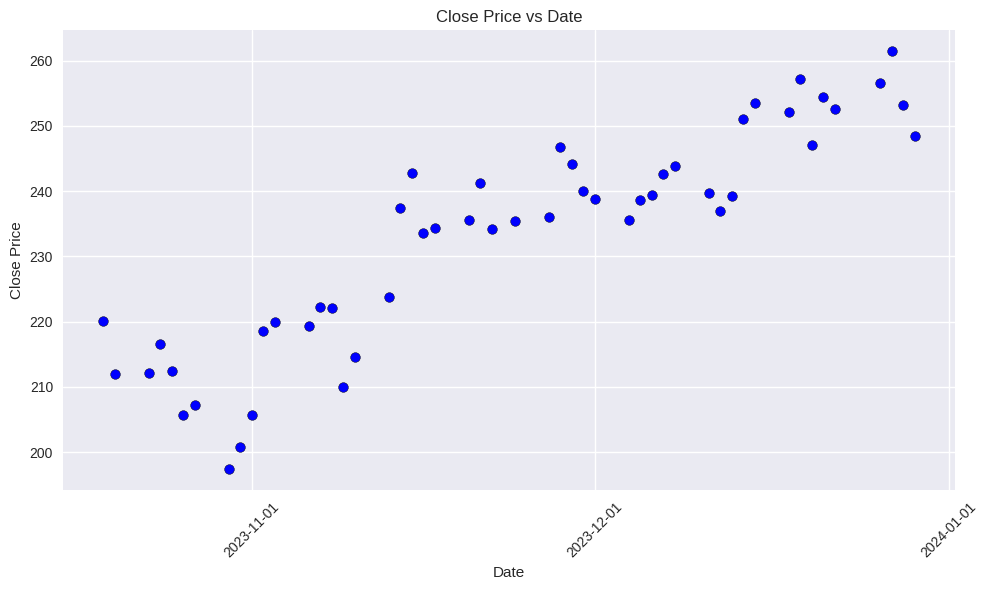

,index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2023-10-19,200,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
2023-10-20,201,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
2023-10-23,202,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
2023-10-24,203,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
2023-10-25,204,215.880005,220.100006,212.199997,212.419998,212.419998,107065100


In [ ]:
plot_open_vs_high(test)
test.head()

# 2. Feature Engineering

In [ ]:
df.describe()

,index,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,124.500000,217.075040,221.631680,212.674320,217.475240,217.475240,1.373222e+08
std,72.312977,42.282592,42.458512,41.831715,41.916800,41.916800,3.577310e+07
min,0.000000,103.000000,111.750000,101.809998,108.099998,108.099998,6.512520e+07
25%,62.250000,186.375004,189.937500,182.912502,186.122494,186.122494,1.117632e+08
50%,124.500000,223.564995,226.555000,218.019997,222.144997,222.144997,1.285824e+08
75%,186.750000,251.787495,257.992500,247.394993,253.019993,253.019993,1.578840e+08
max,249.000000,296.040009,299.290009,289.519989,293.339996,293.339996,3.065906e+08


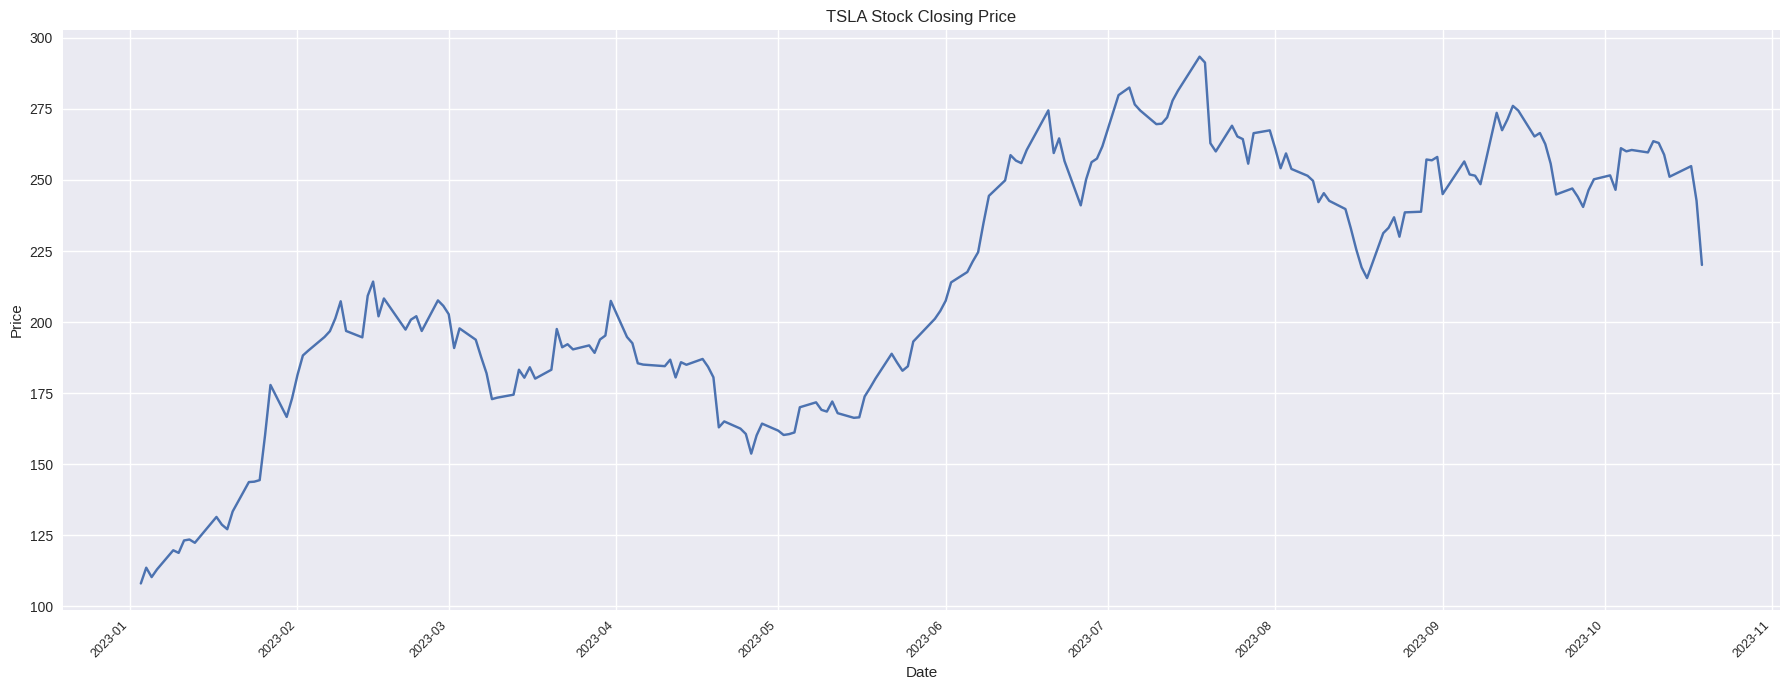

In [ ]:
# Plot the closing price
plt.figure(figsize=(18, 7))
plt.plot(train.index, train['Close'])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9) # Rotate date labels for better readability

plt.tight_layout()
plt.show()

## 2.1 Add Extra Features

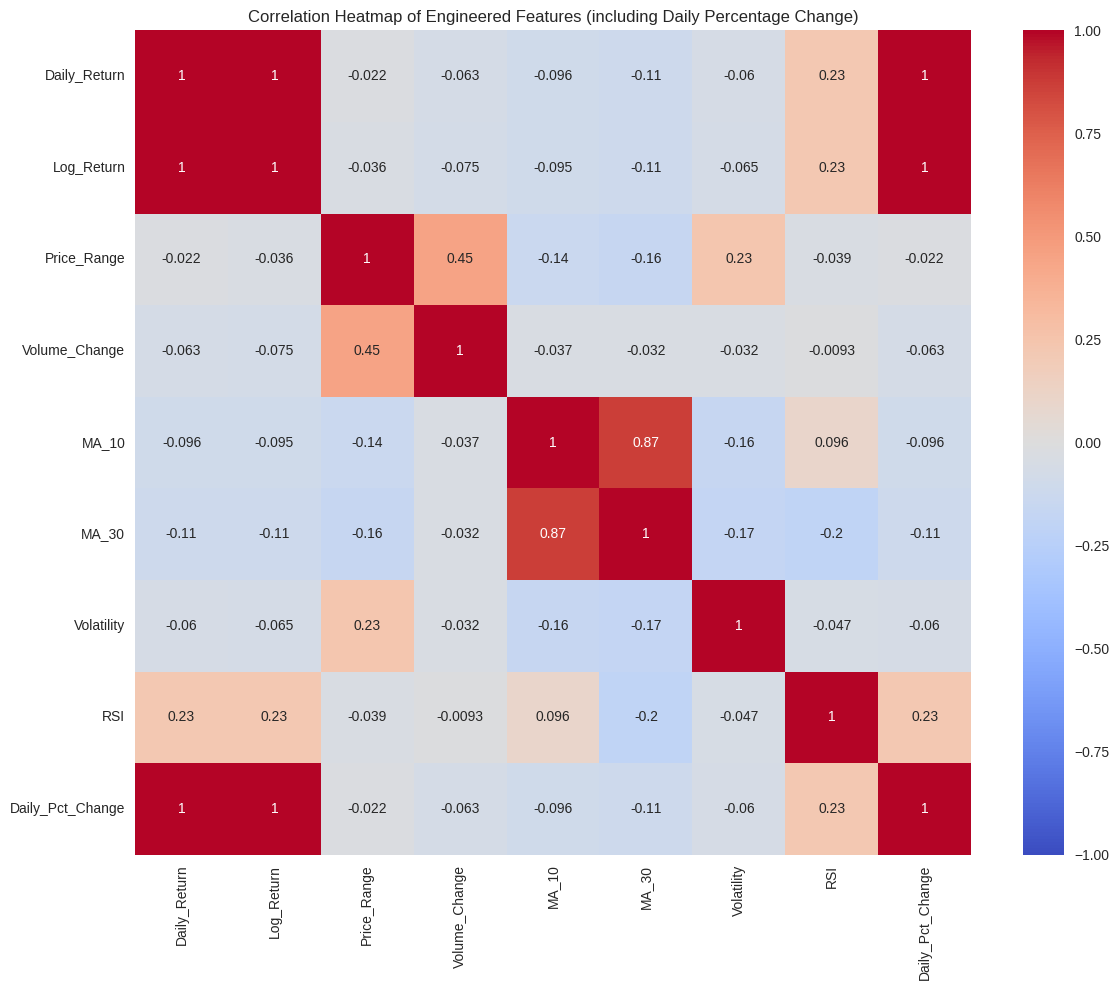

,Daily_Return,Log_Return,Price_Range,Volume_Change,MA_10,MA_30,Volatility,RSI,Daily_Pct_Change
Date,,,,,,,,,
2023-02-14,0.075062,0.072378,0.106179,0.254994,196.062000,154.817999,0.736308,37.911532,7.506166
2023-02-15,0.023847,0.023567,0.040376,-0.163772,199.345000,158.356000,0.716839,35.503543,2.384710
2023-02-16,-0.056946,-0.058631,0.075007,0.268389,200.721999,161.302666,0.764844,21.659554,-5.694554
2023-02-17,0.031033,0.030562,0.054703,-0.069028,202.554999,164.568333,0.759788,33.136423,3.103348
2023-02-21,-0.052518,-0.053947,0.060930,-0.157762,202.815999,167.378666,0.777480,22.610382,-5.251789


In [ ]:
# Feature Engineering (including previous features)
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']
df['Volume_Change'] = df['Volume'].pct_change()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
df['RSI'] = 100 - (100 / (1 + df['Daily_Return'].rolling(14).mean() / abs(df['Daily_Return']).rolling(14).mean()))

# Add Daily Percentage Change
df['Daily_Pct_Change'] = df['Close'].pct_change() * 100

# Remove rows with NaN values
df_clean = df.dropna()

# Select features for correlation analysis
features = ['Daily_Return', 'Log_Return', 'Price_Range', 'Volume_Change', 'MA_10', 'MA_30', 'Volatility', 'RSI', 'Daily_Pct_Change']

# Calculate correlation matrix
correlation_matrix = df_clean[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Engineered Features (including Daily Percentage Change)')
plt.tight_layout()
plt.show()

correlation_matrix

# Display the first few rows of the new dataset
df_clean[features].head()

## 2.3 Plot Stock Analysis Charts

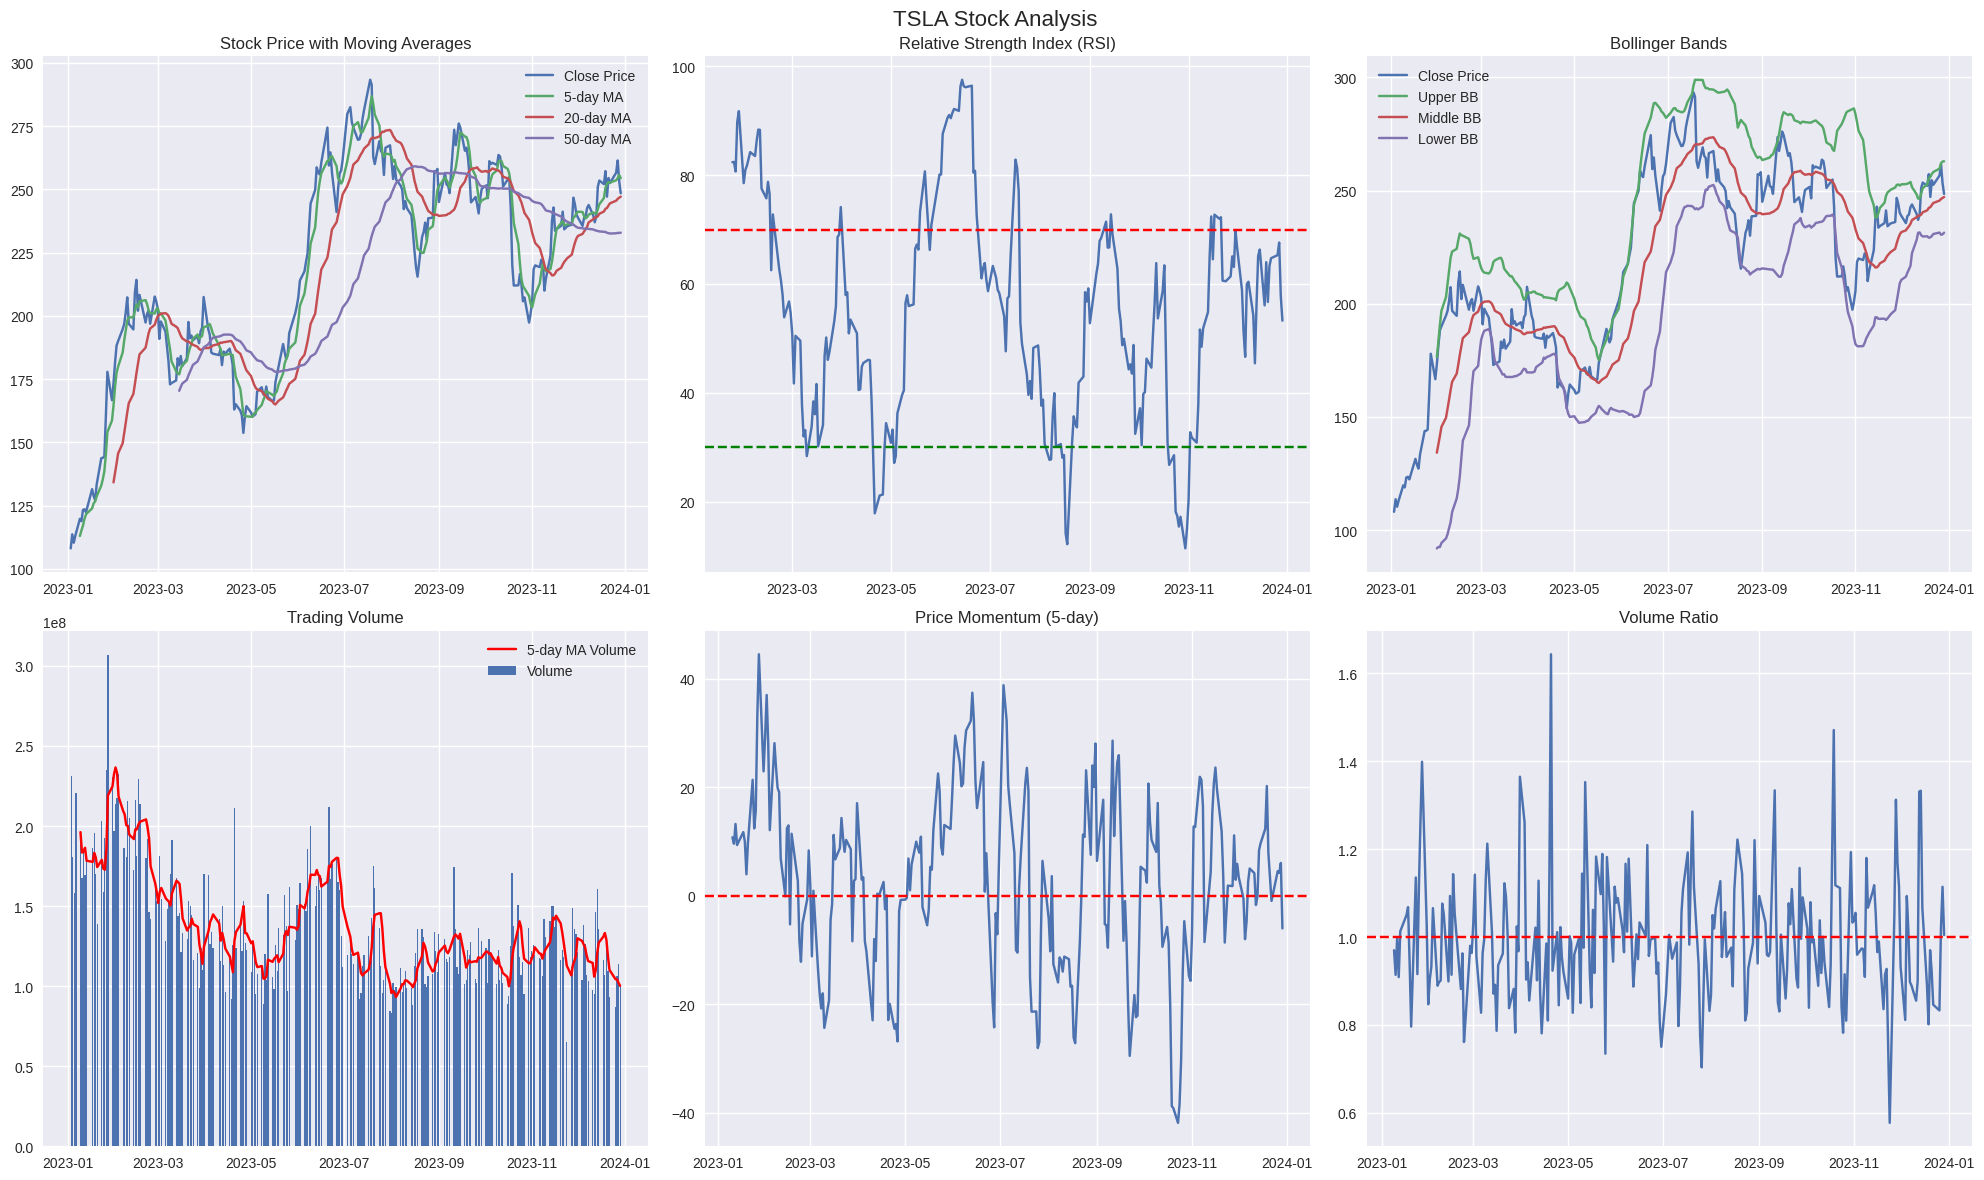

In [ ]:
# Calculate missing columns and add them to the DataFrame
# Moving Averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
std = df['Close'].rolling(window=20).std()
df['BB_middle'] = df['MA20']
df['BB_upper'] = df['BB_middle'] + (std * 2)
df['BB_lower'] = df['BB_middle'] - (std * 2)

# Volume Moving Average
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

# Price Momentum
df['Price_Momentum'] = df['Close'].diff(periods=5)

# Volume Ratio
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']



# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('TSLA Stock Analysis', fontsize=16)

# 1. Moving Averages
axs[0, 0].plot(df.index, df['Close'], label='Close Price')
axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
axs[0, 0].set_title('Stock Price with Moving Averages')
axs[0, 0].legend()

# 2. RSI
axs[0, 1].plot(df.index, df['RSI'], label='RSI')
axs[0, 1].set_title('Relative Strength Index (RSI)')
axs[0, 1].axhline(y=70, color='r', linestyle='--')
axs[0, 1].axhline(y=30, color='g', linestyle='--')

# 3. Bollinger Bands
axs[0, 2].plot(df.index, df['Close'], label='Close Price')
axs[0, 2].plot(df.index, df['BB_upper'], label='Upper BB')
axs[0, 2].plot(df.index, df['BB_middle'], label='Middle BB')
axs[0, 2].plot(df.index, df['BB_lower'], label='Lower BB')
axs[0, 2].set_title('Bollinger Bands')
axs[0, 2].legend()

# 4. Volume
axs[1, 0].bar(df.index, df['Volume'], label='Volume')
axs[1, 0].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
axs[1, 0].set_title('Trading Volume')
axs[1, 0].legend()

# 5. Price Momentum
axs[1, 1].plot(df.index, df['Price_Momentum'], label='Price Momentum')
axs[1, 1].set_title('Price Momentum (5-day)')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

# 6. Volume Ratio
axs[1, 2].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
axs[1, 2].set_title('Volume Ratio')
axs[1, 2].axhline(y=1, color='r', linestyle='--')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#3. Exploratory Data Analysis

In [ ]:
df.isnull().sum()

,0
index,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Daily_Return,1
Log_Return,1
Price_Range,0


## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

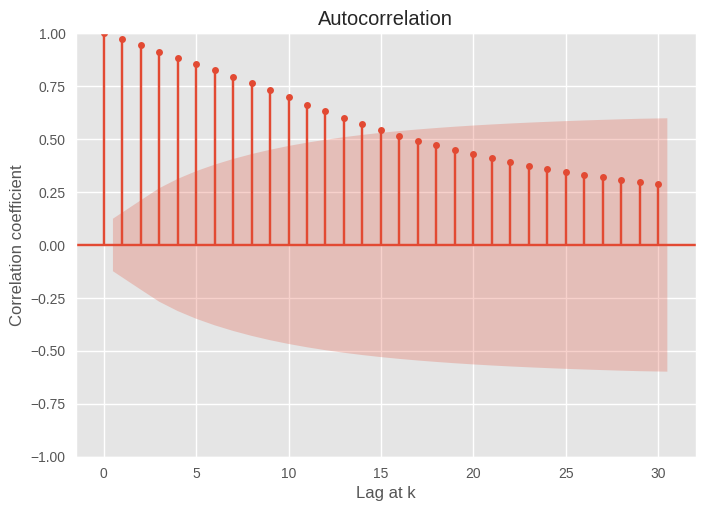

In [ ]:
numerical_data = df['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

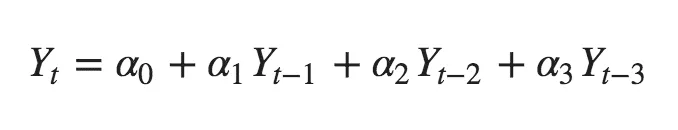

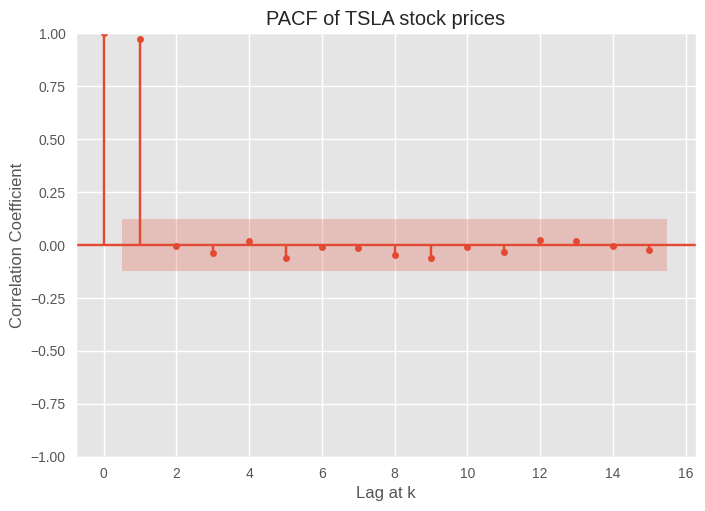

In [ ]:
# numerical_data = df['Close']

plt.style.use('ggplot')
plot_pacf(df['Close'], lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

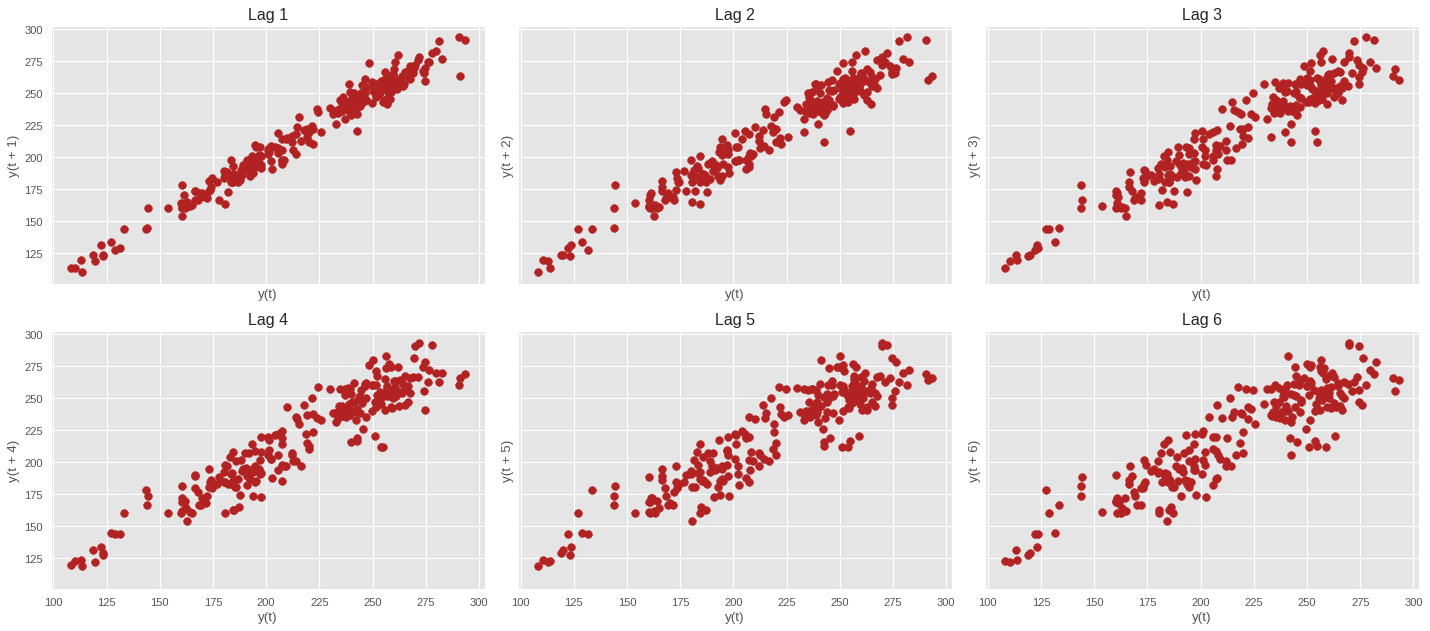

In [ ]:
# numerical_data = df['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(df['Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

In [ ]:
df

,index,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Log_Return,Price_Range,...,Daily_Pct_Change,MA5,MA20,MA50,BB_middle,BB_upper,BB_lower,Volume_MA5,Price_Momentum,Volume_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,0,118.470001,118.800003,104.639999,108.099998,108.099998,231402800,NaN,NaN,0.119524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,1,109.110001,114.589996,107.519997,113.639999,113.639999,180389000,0.051249,0.049979,0.064797,...,5.124885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,2,110.510002,111.750000,107.160004,110.339996,110.339996,157986300,-0.029039,-0.029469,0.041535,...,-2.903910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-06,3,103.000000,114.389999,101.809998,113.059998,113.059998,220911100,0.024651,0.024352,0.122136,...,2.465109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-09,4,118.959999,123.519997,117.110001,119.769997,119.769997,190284000,0.059349,0.057655,0.053884,...,5.934901,112.981998,NaN,NaN,NaN,NaN,NaN,196194640.0,NaN,0.969874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,245,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,-0.007701,-0.007731,0.026679,...,-0.770140,252.695999,244.503500,232.553000,244.503500,258.203263,230.803736,110218980.0,-0.960007,0.846041
2023-12-26,246,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,0.016116,0.015988,0.019883,...,1.611623,253.601996,245.529999,232.662800,245.529999,259.642586,231.417411,104314160.0,4.529984,0.832988
2023-12-27,247,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,0.018822,0.018647,0.022528,...,1.882241,254.445996,246.265999,232.813200,246.265999,262.073476,230.458522,104265560.0,4.220001,1.021377


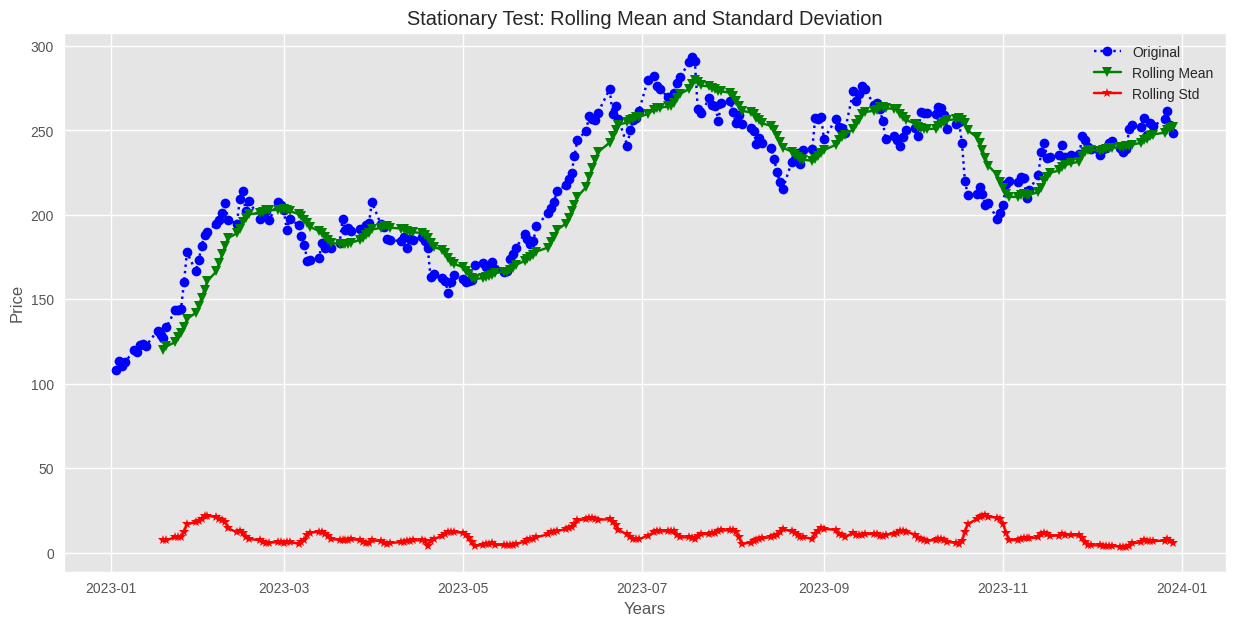

In [ ]:
# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean =  df['Close'].rolling(window=12).mean()
rolling_std =  df['Close'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df.index,  df['Close'], 'b:', marker='o', label='Original')
plt.plot(df.index, rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df.index, rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary
> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

In [ ]:
def plot_differenced_data(df):
    # Ensure 'Close' column is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Drop rows with NaN values that may result from conversion
    df = df.dropna(subset=['Close'])

    # First order differencing
    df_tsla_stock = df[['Close']].diff(1).bfill()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df_tsla_stock['Close'], 'b-.')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.title('Convert Non-Stationary Data to Stationary Data Using Differencing')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

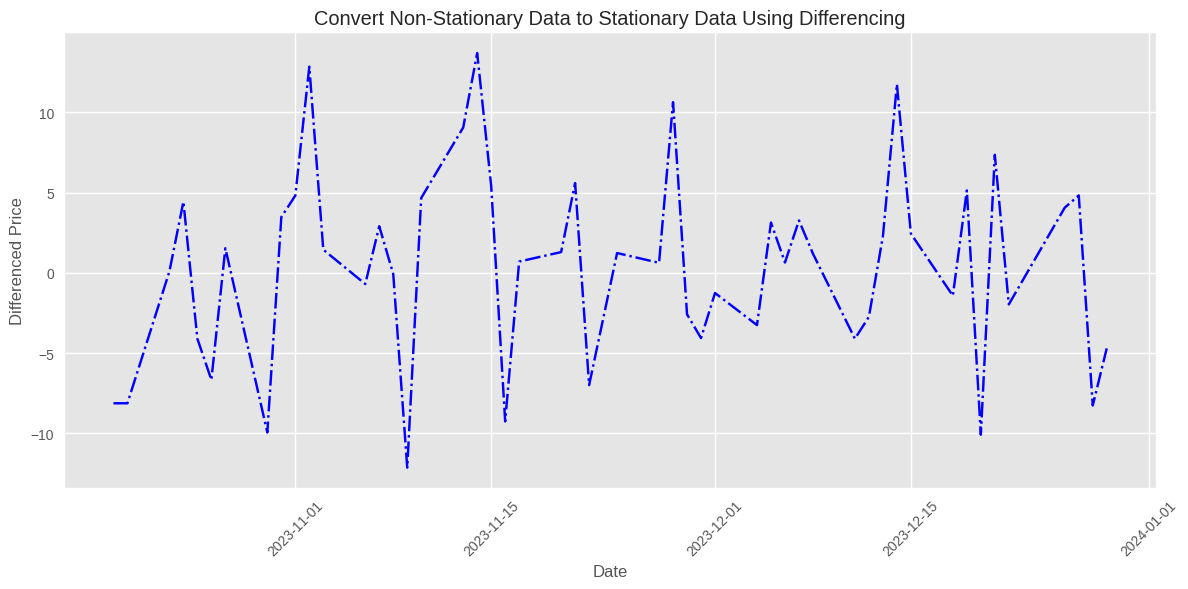

In [ ]:
plot_differenced_data(test)


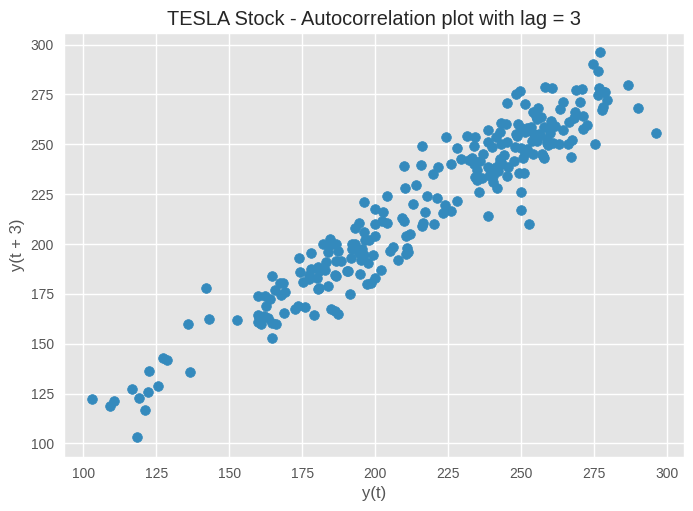

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Simple ARIMA

In [ ]:
class ArimaModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the ARIMAModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMA modeling.
        """
        # Ensure the target column exists
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test))
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100 if not np.all(self.test == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMA model order based on the lowest MSE.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMA(p={p}, d={d}, q={q}) MSE: {mse:.4f}')  # Display the ARIMA order and MSE

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best ARIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMA order
        plt.title(f'Stock Price Forecast (ARIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()


    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMA model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

In [ ]:
train.dtypes

,0
index,int64
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [ ]:
arima_model = ArimaModel(train, test, target_column='Close')

In [ ]:
# Perform grid search
arima_model.grid_search()

ARIMA(p=0, d=0, q=0) MSE: 644.3571
ARIMA(p=0, d=0, q=1) MSE: 657.1119
ARIMA(p=0, d=0, q=2) MSE: 670.1830
ARIMA(p=0, d=1, q=0) MSE: 437.5246
ARIMA(p=0, d=1, q=1) MSE: 434.8640
ARIMA(p=0, d=1, q=2) MSE: 440.7654
ARIMA(p=0, d=2, q=0) MSE: 462272.2971
ARIMA(p=0, d=2, q=1) MSE: 2428.7719
ARIMA(p=0, d=2, q=2) MSE: 3945.4905
ARIMA(p=1, d=0, q=0) MSE: 751.0312
ARIMA(p=1, d=0, q=1) MSE: 751.9681
ARIMA(p=1, d=0, q=2) MSE: 767.7354
ARIMA(p=1, d=1, q=0) MSE: 434.8413
ARIMA(p=1, d=1, q=1) MSE: 1005.1091
ARIMA(p=1, d=1, q=2) MSE: 469.3656
ARIMA(p=1, d=2, q=0) MSE: 332024.8254
ARIMA(p=1, d=2, q=1) MSE: 3767.5838
ARIMA(p=1, d=2, q=2) MSE: 3648.0640
ARIMA(p=2, d=0, q=0) MSE: 751.7475
ARIMA(p=2, d=0, q=1) MSE: 726.3992
ARIMA(p=2, d=0, q=2) MSE: 811.3112
ARIMA(p=2, d=1, q=0) MSE: 443.4592
ARIMA(p=2, d=1, q=1) MSE: 1121.7099
ARIMA(p=2, d=1, q=2) MSE: 1086.0552
ARIMA(p=2, d=2, q=0) MSE: 212425.3114
ARIMA(p=2, d=2, q=1) MSE: 5182.2671
ARIMA(p=2, d=2, q=2) MSE: 2240.9379
Best order found: (1, 1, 0) with MSE:

In [ ]:
# Fit the best model
arima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
arima_model.make_forecast()

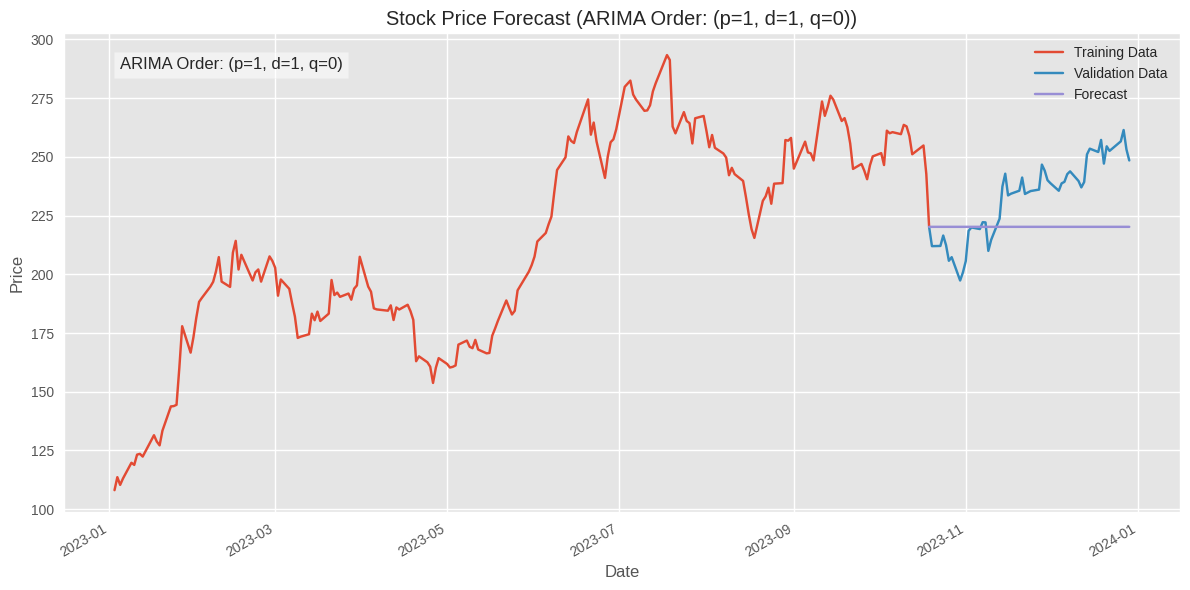

In [ ]:
arima_model.plot_results()

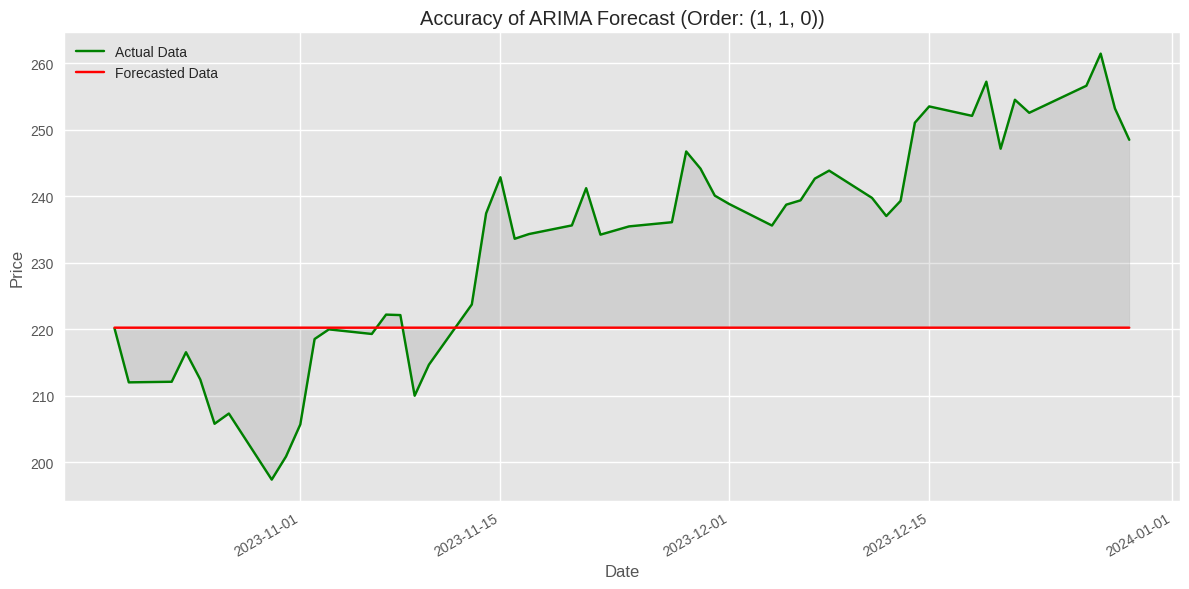

In [ ]:
arima_model.plot_accuracy()

In [ ]:
# Print evaluation metrics and model summary
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 434.84125359421375
Final Mean Absolute Error: 17.91326069591888
Final Root Mean Squared Error: 20.852847613556612


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  201
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -681.521
Date:                Wed, 14 Aug 2024   AIC                           1367.041
Time:                        10:36:56   BIC                           1373.638
Sample:                             0   HQIC                          1369.711
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0047      0.073     -0.064      0.949      -0.149       0.139
sigma2        53.3742      4.090     13.051      0.000      45.359      61.390
Ljung-Box (L1) (Q):                   0.01   Jarque-Be

In [ ]:
# Display the top 5 model orders
arima_model.display_top_orders()

Top 5 ARIMA model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
12,"(1, 1, 0)",434.841254,17.913261,20.852848,NaN,NaN,NaN,-0.586734,-0.690217,1367.041316,1373.637950
4,"(0, 1, 1)",434.864021,17.913610,20.853394,NaN,NaN,NaN,-0.586817,-0.690305,1367.041393,1373.638028
3,"(0, 1, 0)",437.524649,17.955399,20.917090,NaN,NaN,NaN,-0.596526,-0.700647,1365.045524,1368.343842
5,"(0, 1, 2)",440.765402,18.008849,20.994414,NaN,NaN,NaN,-0.608351,-0.713244,1369.029435,1378.924387
21,"(2, 1, 0)",443.459179,18.055579,21.058470,NaN,NaN,NaN,-0.618181,-0.723714,1369.024475,1378.919428


## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


In [ ]:
class ARIMAXModel:
    def __init__(self, train, test, target_column, exog_vars):
        """
        Initializes the ARIMAXModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMAX modeling.
        exog_vars (list): List of exogenous variables to use in the model.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.exog_vars = exog_vars

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train[exog_vars]
        self.test_exog = test[exog_vars]

        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps)
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / denominator)

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        if d == 0:
            return float('inf')  # Returning infinity if naive forecast method is not valid
        return np.abs(y_true - y_pred).mean() / d

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test), exog=self.test_exog)
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = self.mean_absolute_percentage_error(self.test, forecast)
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMAX model order based on the lowest MSE.
        """
        p = d = q = range(0, 3)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, exog=self.train_exog, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMAX(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, exog=self.train_exog, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMAX model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test), exog=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMAX (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMAX order
        plt.title(f'Stock Price Forecast (ARIMAX Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMAX Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMAX' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMAX")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMAX model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMAX model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMAX model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast


In [ ]:
# Initialize the model
arimax_model = ARIMAXModel(train=train, test=test, target_column='Close', exog_vars=['Open', 'High', 'Low', 'Volume'])

In [ ]:
# Perform grid search
arimax_model.grid_search()

ARIMAX(p=0, d=0, q=0) MSE: 6.1967
ARIMAX(p=0, d=0, q=1) MSE: 6.2229
ARIMAX(p=0, d=0, q=2) MSE: 6.2686
ARIMAX(p=0, d=1, q=0) MSE: 16.5558
ARIMAX(p=0, d=1, q=1) MSE: 10.0472
ARIMAX(p=0, d=1, q=2) MSE: 10.0839
ARIMAX(p=0, d=2, q=0) MSE: 34379.8887
ARIMAX(p=0, d=2, q=1) MSE: 34379.8887
ARIMAX(p=0, d=2, q=2) MSE: 34379.8887
ARIMAX(p=1, d=0, q=0) MSE: 6.2099
ARIMAX(p=1, d=0, q=1) MSE: 6.1967
ARIMAX(p=1, d=0, q=2) MSE: 6.2695
ARIMAX(p=1, d=1, q=0) MSE: 12.9600
ARIMAX(p=1, d=1, q=1) MSE: 10.3510
ARIMAX(p=1, d=1, q=2) MSE: 16.5558
ARIMAX(p=1, d=2, q=0) MSE: 27216.2242
ARIMAX(p=1, d=2, q=1) MSE: 1444.0097
ARIMAX(p=1, d=2, q=2) MSE: 29396.0401
ARIMAX(p=2, d=0, q=0) MSE: 6.2793
ARIMAX(p=2, d=0, q=1) MSE: 6.4019
ARIMAX(p=2, d=0, q=2) MSE: 5.8644
ARIMAX(p=2, d=1, q=0) MSE: 10.6393
ARIMAX(p=2, d=1, q=1) MSE: 10.6731
ARIMAX(p=2, d=1, q=2) MSE: 16.5558
ARIMAX(p=2, d=2, q=0) MSE: 14687.7305
ARIMAX(p=2, d=2, q=1) MSE: 3062.1851
ARIMAX(p=2, d=2, q=2) MSE: 21171.1581
Best order found: (2, 0, 2) with MSE: 5

In [ ]:
# Fit the best model
arimax_model.fit_best_model()

In [ ]:
# Make the forecast
arimax_model.make_forecast()

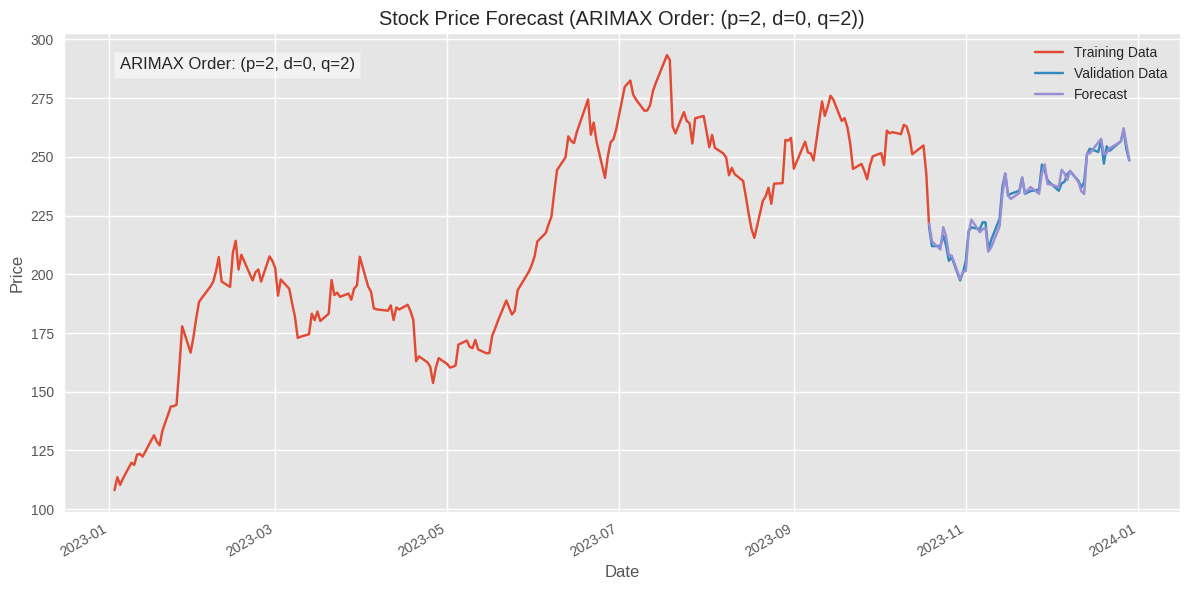

In [ ]:
# Plot the results
arimax_model.plot_results()

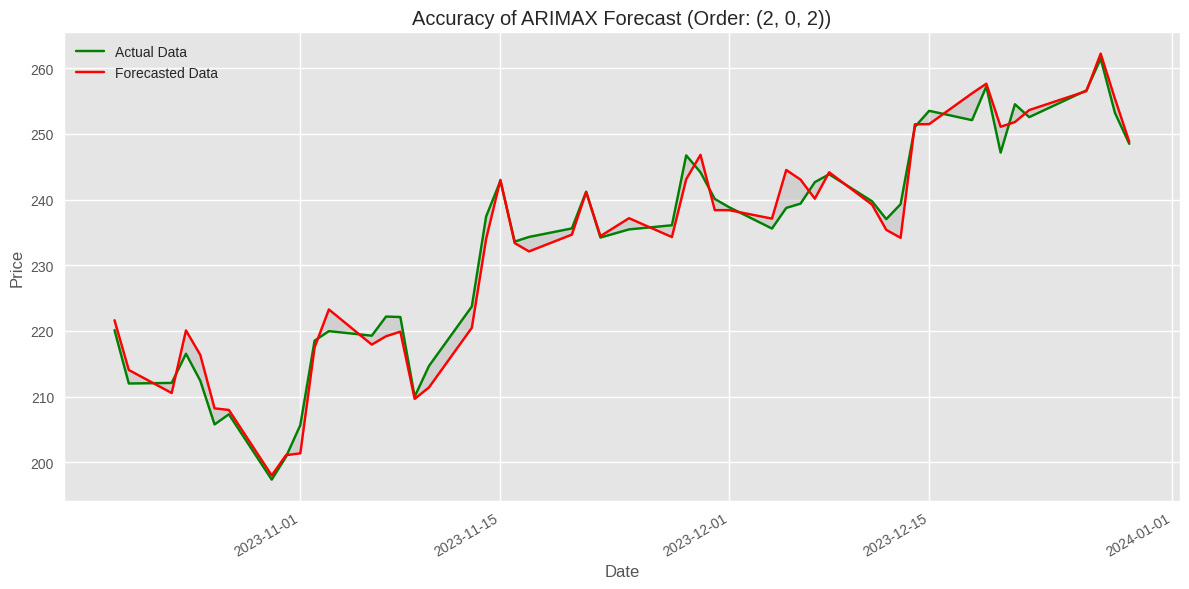

In [ ]:
# Plot forecast accuracy
arimax_model.plot_accuracy()

In [ ]:
# Print evaluation metrics
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 5.864389758798971
Final Mean Absolute Error: 1.9355007490785072
Final Root Mean Squared Error: 2.4216502139654628


In [ ]:
# Print model summary
arimax_model.print_model_summary()

                               ARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  201
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -454.308
Date:                Wed, 14 Aug 2024   AIC                            928.616
Time:                        10:37:06   BIC                            961.649
Sample:                             0   HQIC                           941.982
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4015   2.45e-05   9.81e+04      0.000       2.401       2.402
Open          -0.7219      0.001   -902.912      0.000      -0.723      -0.720
High           0.7895      0.001   1115.685      0.00

In [ ]:
# Display top model orders
arimax_model.display_top_orders(top_n=5)

Top 5 ARIMAX model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
20,"(2, 0, 2)",5.864390,1.935501,2.421650,0.837992,0.837951,0.406949,0.978601,0.977205,928.615661,961.648710
0,"(0, 0, 0)",6.196688,2.004033,2.489315,0.870339,0.870364,0.421358,0.977388,0.975914,1796.164354,1815.984184
10,"(1, 0, 1)",6.196688,2.004033,2.489315,0.870339,0.870364,0.421358,0.977388,0.975914,934.472093,960.898532
9,"(1, 0, 0)",6.209908,2.007457,2.491969,0.871887,0.871898,0.422078,0.977340,0.975862,929.734456,952.857590
1,"(0, 0, 1)",6.222873,2.010804,2.494569,0.873416,0.873414,0.422782,0.977293,0.975812,928.321113,951.444247


In [ ]:
# Get the best order and forecast
best_order = arimax_model.get_best_order()


In [ ]:
forecast = arimax_model.get_forecast()

## 4.3 Autoregressive fractionally integrated moving average (AFRIMA)

In [ ]:
class AFRIMAModel:
    def __init__(self, train, test, train_exog, test_exog, target_column, exog_vars):
        """
        Initializes the AFRIMAModel with the given parameters.

        Parameters:
        train (pd.DataFrame): The training dataset containing the target variable and exogenous variables.
        test (pd.DataFrame): The testing dataset containing the target variable and exogenous variables.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        target_column (str): The name of the target variable in the train and test datasets.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train_exog[exog_vars]
        self.test_exog = test_exog[exog_vars]
        self.exog_vars = exog_vars

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf') 

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            model_fit = model.fit(self.train, exogenous=self.train_exog)
            forecast = model_fit.predict_in_sample()
            mse = mean_squared_error(self.train, forecast)
            mae = mean_absolute_error(self.train, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.train - forecast) / self.train)) * 100 if not np.all(self.train == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.train, forecast)
            mase = self.mean_absolute_scaled_error(self.train, forecast)
            r_squared = r2_score(self.train, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.train), len(order))
            aic_value = model_fit.aic()
            bic_value = model_fit.bic()

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order (p={order[0]}, d={order[1]}, q={order[2]}): {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal AFRIMA model order based on the lowest MSE.
        """
        p = q = range(0, 6) 
        d_values = np.linspace(0, 1, 6)

        pdq = list(itertools.product(p, d_values, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param
                model = auto_arima(self.train, exogenous=self.train_exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'AFRIMA(p={p}, d={d:.2f}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d:.2f}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best AFRIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = auto_arima(self.train, exogenous=self.train_exog, order=self.best_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        self.best_model = self.best_model.fit(self.train, exogenous=self.train_exog)

    def make_forecast(self):
        """
        Makes forecast using the best fitted AFRIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.predict(n_periods=len(self.test), exogenous=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the AFRIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with AFRIMA order
        plt.title(f'Stock Price Forecast (AFRIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'AFRIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of AFRIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'AFRIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'AFRIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "AFRIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("\nModel Coefficients:")
        for param_name, value in zip(self.best_model.arima_res_.params.index, self.best_model.arima_res_.params):
            print(f"{param_name}: {value:.4f}")


    def display_top_orders(self, top_n=5):
        """
        Displays the top N AFRIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} AFRIMA model orders with the lowest MSE:")
        # display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

In [ ]:
exog_vars = ['Volume', 'Open', 'High', 'Low']

# # Exogenous variables
train_exog = train[exog_vars]
test_exog = test[exog_vars]

# Initialize the AFRIMAModel
afrima_model = AFRIMAModel(train, test, train_exog, test_exog, target_column, exog_vars)

In [ ]:
# Perform grid search
afrima_model.grid_search()

AFRIMA(p=0, d=0.00, q=0) MSE: 111.2472
AFRIMA(p=0, d=0.00, q=1) MSE: 111.2472
AFRIMA(p=0, d=0.00, q=2) MSE: 111.2472
AFRIMA(p=0, d=0.00, q=3) MSE: 111.2472
AFRIMA(p=0, d=0.00, q=4) MSE: 111.2472
AFRIMA(p=0, d=0.00, q=5) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=0) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=1) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=2) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=3) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=4) MSE: 111.2472
AFRIMA(p=0, d=0.20, q=5) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=0) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=1) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=2) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=3) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=4) MSE: 111.2472
AFRIMA(p=0, d=0.40, q=5) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=0) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=1) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=2) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=3) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=4) MSE: 111.2472
AFRIMA(p=0, d=0.60, q=5) MSE: 111.2472
AFRIMA(p=0, d=0.80, q=0) MSE: 111.2472
AFRIMA(p=0, d=0.80, q=1) 

In [ ]:
top_orders = afrima_model.display_top_orders()

Top 5 AFRIMA model orders with the lowest MSE:


In [ ]:
afrima_model.print_model_summary()

                               AFRIMA Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               AFRIMA(0, 1, 0)   Log Likelihood                -681.523
Date:                Wed, 14 Aug 2024   AIC                           1365.046
Time:                        10:39:59   BIC                           1368.344
Sample:                             0   HQIC                          1366.380
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        53.3754      4.038     13.218      0.000      45.461      61.290
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                21.28
Prob(Q):                              0.87   Prob

In [ ]:
# # Fit the best model
afrima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
afrima_model.make_forecast()

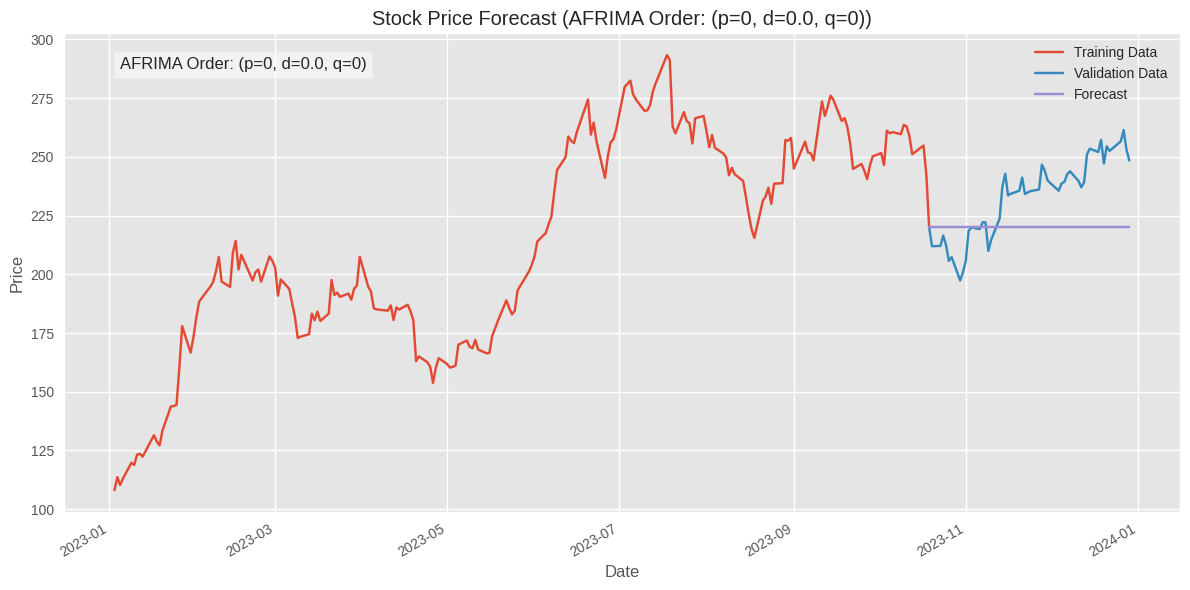

In [ ]:
afrima_model.plot_results()

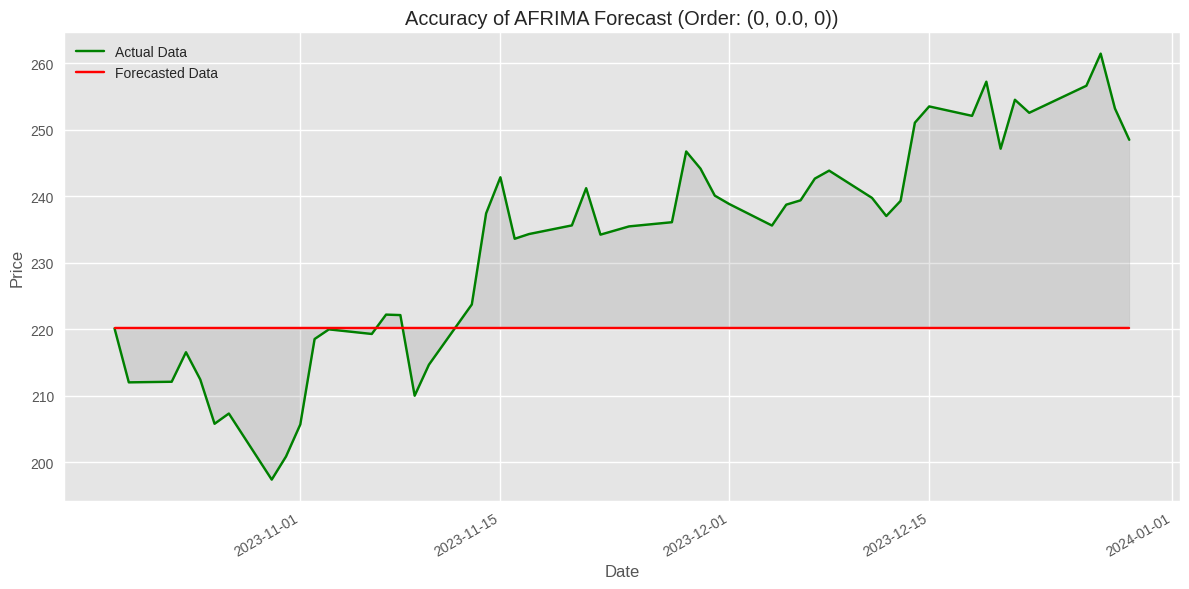

In [ ]:
afrima_model.plot_accuracy()

In [ ]:
afrima_model.print_evaluation_metrics()

Final Mean Squared Error: 437.52464852712114
Final Mean Absolute Error: 17.955399169921876
Final Root Mean Squared Error: 20.917089867549002


# 6. Long Short-Term Memory (LSTM)

## 6.1 LSTM

In [ ]:
class LSTMModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the LSTMModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for LSTM modeling.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Scale the data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.train = self.scaler.fit_transform(train[[target_column]].values)
        self.test = self.scaler.transform(test[[target_column]].values)

        self.train_len = len(self.train)
        self.test_len = len(self.test)

        self.train_dates = train.index
        self.test_dates = test.index

        self.model = None
        self.predictions = None
        self.rmse = None
        self.results_df = pd.DataFrame(columns=[
            'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared'
        ])

    def prepare_data(self, data, time_step=60):
        x, y = [], []
        for i in range(time_step, len(data)):
            x.append(data[i-time_step:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.35))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model

    def fit(self, epochs=2, batch_size=1):
        x_train, y_train = self.prepare_data(self.train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        self.model = self.build_model((x_train.shape[1], 1))

        # Plot model architecture
        plot_model(self.model, show_shapes=True, show_layer_names=True, to_file='lstm_model_architecture.png')

        history = self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

        # Plot training & validation loss values
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
        plt.title('Model Training Loss and Accuracy')
        plt.ylabel('Value')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def predict(self):
        x_test, y_test = self.prepare_data(np.concatenate((self.train[-60:], self.test)))

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        self.predictions = self.model.predict(x_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)

        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))
        self.rmse = np.sqrt(np.mean((self.predictions - y_test) ** 2))

        return self.predictions, y_test, self.rmse

    def plot_results(self, train, test):
        train_values = train[self.target_column].values
        test_values = test[self.target_column].values

        pred_dates = test.index

        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train_values, label='Train', color='#39304A', linestyle='-')
        plt.plot(pred_dates, test_values, label='Valid', color='#A98D75', linestyle='-')
        plt.plot(pred_dates, self.predictions.reshape(-1), label='Predictions', color='#FFAA00', linestyle='-')

        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.title('LSTM Model Results')
        plt.legend()
        plt.xticks(rotation=45)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.gcf().autofmt_xdate()

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate_model(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
        mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))
        r_squared = r2_score(y_true, y_pred)
        adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - 1 - 1)

        evaluation_results = pd.DataFrame([{
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared
        }])

        self.results_df = pd.concat([self.results_df, evaluation_results], ignore_index=True)
        return evaluation_results


In [ ]:
lstm_model = LSTMModel(train, test, target_column)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.0000e+00 - loss: 0.2694
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.0037 - loss: 0.0729
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.0132 - loss: 0.0472
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.0054 - loss: 0.0204
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.0132 - loss: 0.0236
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.0132 - loss: 0.0182
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.0037 - loss: 0.0226
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.0024 - loss: 0.0145
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.0080 - loss: 0.0184
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.0054 - loss: 0.0148


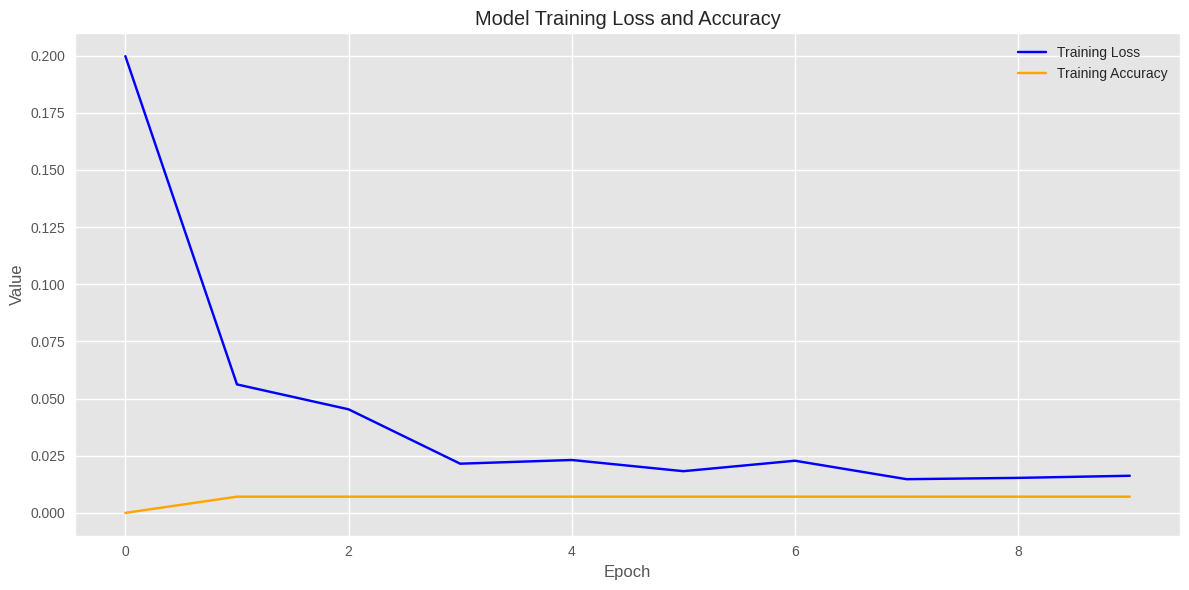

In [ ]:
# Train the model
lstm_model.fit(epochs=10, batch_size=32)

In [ ]:
# Make predictions
predictions, y_test, rmse = lstm_model.predict()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


In [ ]:
print(f'RMSE: {rmse}')

RMSE: 16.27900466408501


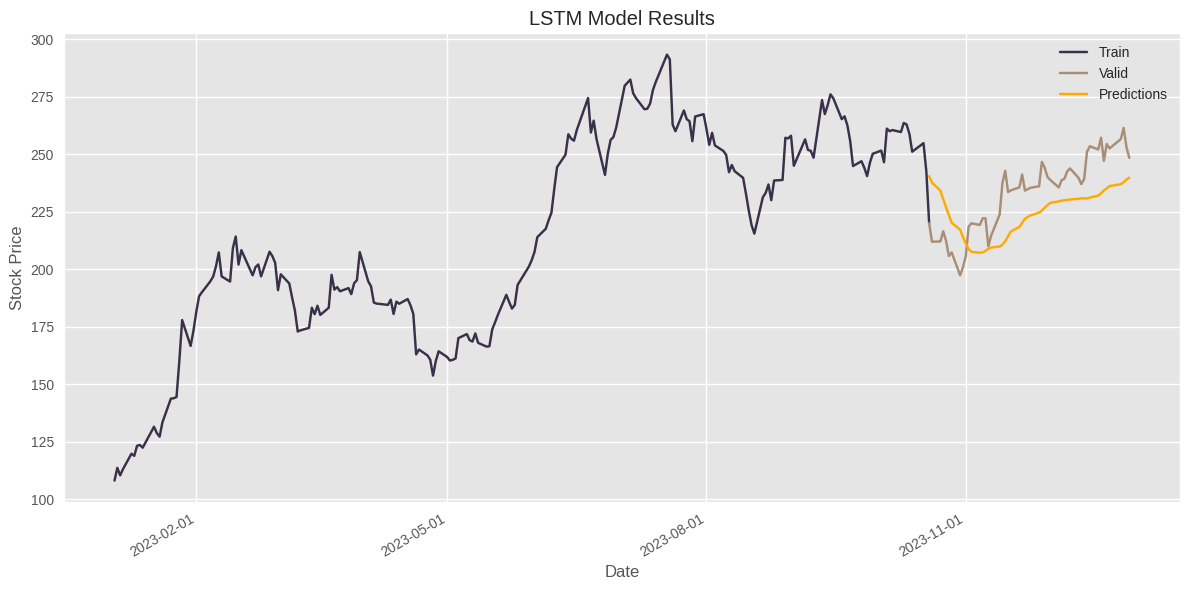

In [ ]:
# Plot the results
lstm_model.plot_results(train, test)

In [ ]:
# Evaluate the model and store the results in a DataFrame
evaluation_results = lstm_model.evaluate_model(y_test, predictions)

In [ ]:
evaluation_results

,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared
0,265.005993,15.076626,16.279005,6.460322,6.574055,3.16994,0.032994,0.012848


In [ ]:
# Display the DataFrame containing the results
lstm_model.results_df

,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared
0,265.005993,15.076626,16.279005,6.460322,6.574055,3.16994,0.032994,0.012848


# Comparison

## Compare forecasts

In [ ]:
def compare_forecasts_and_plot(arima_model, arimax_model, afrima_model, lstm_model, train, test):
    """
    Compare forecasts from ARIMA, ARIMAX, AFRIMA, and LSTM models, and plot the results.

    Parameters:
    arima_model (ArimaModel): Trained ARIMA model object.
    arimax_model (ARIMAXModel): Trained ARIMAX model object.
    afrima_model (AFRIMAModel): Trained AFRIMA model object.
    lstm_model (LSTMModel): Trained LSTM model object.
    train (pd.DataFrame): Training dataset with a DateTime index.
    test (pd.DataFrame): Testing dataset with a DateTime index.
    """

    # Generate forecasts using each model
    arima_model.make_forecast()
    arimax_model.make_forecast()
    afrima_model.make_forecast()
    lstm_forecast, _, _ = lstm_model.predict()

    # Access the forecasts
    arima_forecast = arima_model.forecast
    arimax_forecast = arimax_model.forecast
    afrima_forecast = afrima_model.forecast

    # Extract the date index for the test set
    dates = test.index

    # Plot the forecasts along with the actual test data
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train.index, train[arima_model.target_column], label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(dates, test[arima_model.target_column], label='Actual Data', color='black')

    # Plot ARIMA forecast
    plt.plot(dates, arima_forecast, label=f'ARIMA Forecast (Order: {arima_model.get_best_order()})')

    # Plot ARIMAX forecast
    plt.plot(dates, arimax_forecast, label=f'ARIMAX Forecast (Order: {arimax_model.get_best_order()})')

    # Plot AFRIMA forecast
    plt.plot(dates, afrima_forecast, label=f'AFRIMA Forecast (Order: {afrima_model.get_best_order()})')

    # Plot LSTM forecast
    plt.plot(dates, lstm_forecast, label='LSTM Forecast', color='magenta')

    # Add title and labels
    plt.title('Model Comparison: ARIMA, ARIMAX, AFRIMA, and LSTM Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


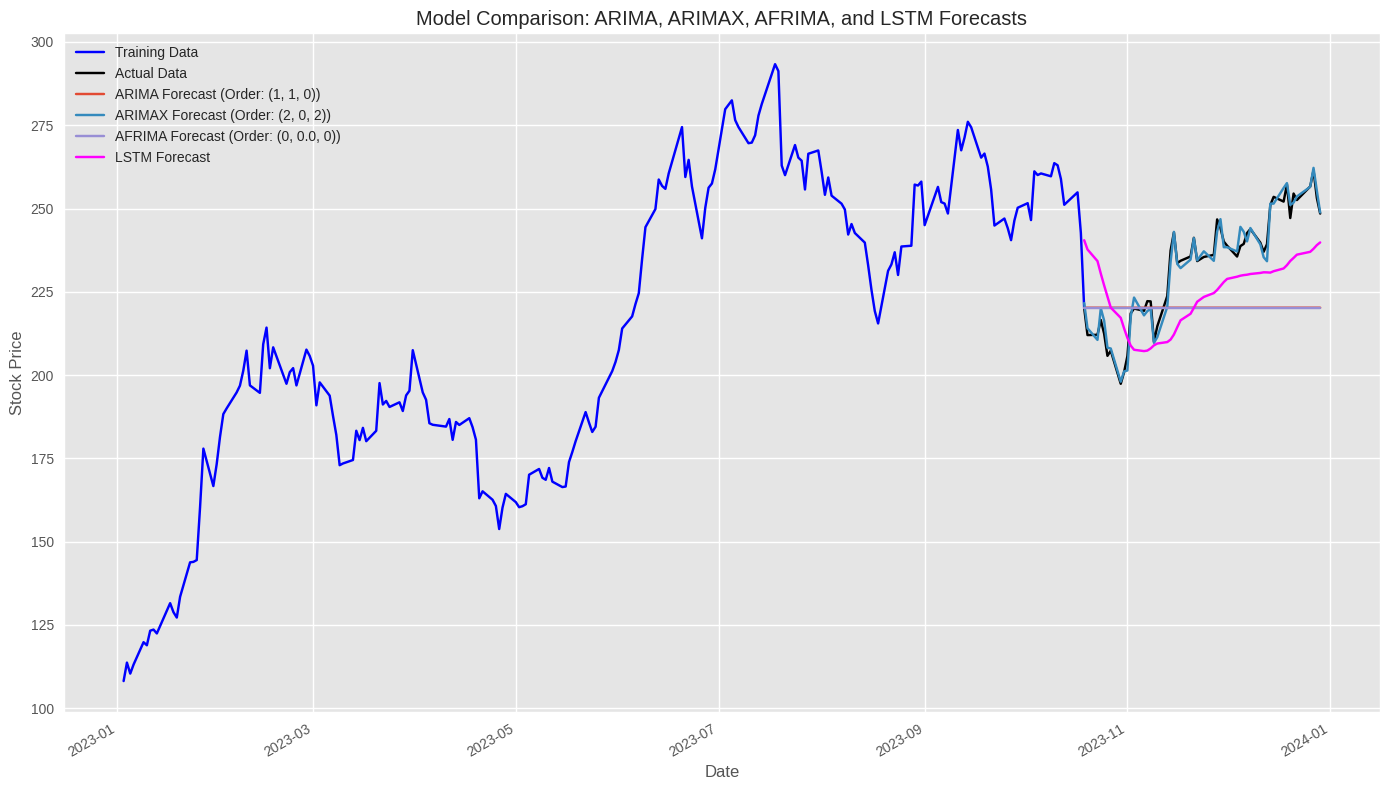

In [ ]:
compare_forecasts_and_plot(arima_model, arimax_model, afrima_model, lstm_model, train, test)

## Evaluate Models